In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# Exercise 1

## A: Power Reflection

In [18]:
N = 32
n1 = 3.5
n2 = 3.1
ld = 900         # nm

L1 = 64.3           # nm
L2 = 77.6           # nm

xlim0 = 800         # nm
xlim1 = 1000        # nm

In [11]:
L2 = ld/(4*n2)
L2

72.58064516129032

In [12]:
# Power reflection
st = 1                                      # nm
lambdas = np.arange(xlim0, xlim1+st, st)    # nm

Rtot = []
Ttot = []
for l in lambdas:
    k0 = 2*np.pi/l
    T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
    TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])

    # build the unit transfer matrix
    Tunit = (np.matmul(np.matmul(np.matmul(TL(L2, n2), T(n1, n2)), TL(L1, n1)), T(n2, n1)))

    Tt = np.identity(len(Tunit))
    for i in range(N):
        Tt = np.matmul(Tt, Tunit)

    Rtot.append(np.abs(np.divide(Tt[0][1], Tt[1][1]))**2)
    Ttot.append(np.absolute(Tt[0][0] - np.divide((Tt[0][1] * Tt[1][0]), Tt[1][1]))**2)

Rtot = np.array(Rtot)
Ttot = np.array(Ttot)

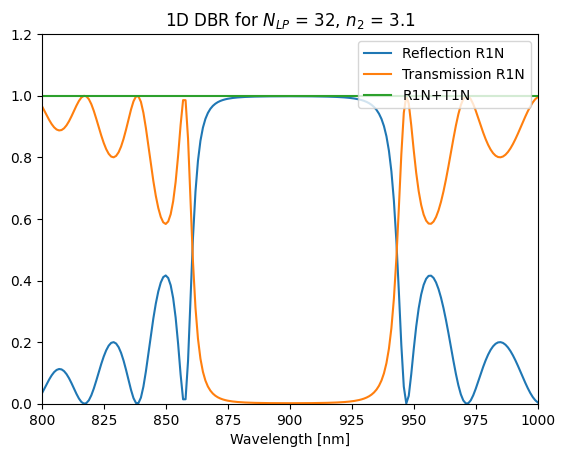

In [13]:
plt.figure()
plt.plot(lambdas, Rtot, label="Reflection R1N")
plt.plot(lambdas, Ttot, label="Transmission R1N")
plt.plot(lambdas, Rtot + Ttot, label="R1N+T1N")
plt.xlabel("Wavelength [nm]")
plt.xlim([xlim0, xlim1])
plt.ylim([0, 1.2])
plt.title("1D DBR for $N_{LP}$ = " + str(N) + ", $n_2$ = " + str(n2))
plt.legend(loc='upper right')
plt.show()

## B: Field profile for a DBR

In [2]:
n1 = 3.5
n2 = 2.9

N = 32

lda = 900             # nm
k0 = 2*np.pi/lda

L1 = lda/(4*n1)
L2 = lda/(4*n2)

AN = np.array([1, 0]).reshape([2,1])

zlim0 = 0           # nm
zlim1 = (L1+L2)*N+L1   # nm

st = 1                                  # nm
zr = np.arange(0, zlim1+st, st)         # nm

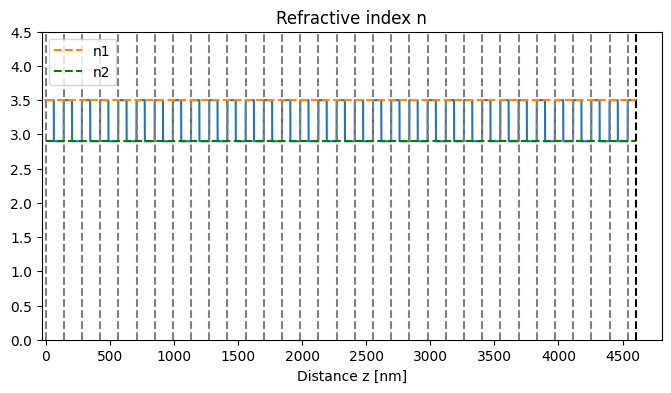

In [3]:
nidx = [n1 if i < L1 else n2 for i in np.arange(0, L1+L2, st)]
nidxek = [n1 for _ in np.arange(0, L1, st)]


nidxt = []
for _ in range(N):
    nidxt = nidxt + nidx
nidxt = nidxt + nidxek

plt.figure(figsize=(8,4))
plt.plot(np.linspace(0, zlim1, len(nidxt)), np.array(nidxt))
plt.axvline(x=max(zr), color="black", linestyle="--")
for hh in np.arange(0, max(zr), L1+L2):
    plt.axvline(x=hh, color="gray", linestyle="--")
plt.hlines(y=n1, xmin=min(zr), xmax=max(zr), color="darkorange", linestyle="--", label="n1")
plt.hlines(y=n2, xmin=min(zr), xmax=max(zr), color="green", linestyle="--", label="n2")
plt.xlim([0-30*st, max(zr)+200*st])
plt.xlabel("Distance z [nm]")
plt.xticks(np.arange(0, max(zr), 500))
plt.ylim([0, 4.5])
plt.title("Refractive index n")
plt.legend()
plt.show()

$ T_t =  T_{L1} * T_{21} * (T_{L2} * T_{12} * T_{L1} * T_{21})^N = T_{L1} * T_{21} * (T_{unit})^N $

In [4]:
# Find the field at z=0

# calculate Tt
T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])

# build the unit transfer matrix
# Tunit = (np.matmul(
#             np.matmul(
#                 np.matmul(TL(L2, n2), 
#                             T(n1, n2)), 
#                                 TL(L1, n1)), 
#                                     T(n2, n1)))

Tt = np.ones((2, 2))
Tt = np.matmul(Tt, TL(L1, n1))
Tt = np.matmul(Tt, T(n2, n1))
for i in range(N):
    Tt = np.matmul(Tt, TL(L2, n2))
    Tt = np.matmul(Tt, T(n1, n2))
    Tt = np.matmul(Tt, TL(L1, n1))
    Tt = np.matmul(Tt, T(n2, n1))

Tts = sparse.csr_matrix(Tt)
Ttinv = np.linalg.pinv(Tts.toarray())

A10 = np.matmul(Ttinv, AN)

In [5]:
np.abs(A10[0][0] + A10[1][0])

4.733227260752171e-08

$
T_t = 
     \begin{cases}
       T_{1}(z) &\quad z < L_1\\
       T_{L1} * T_{21} * T_{2}(z) &\quad L_1 < z < L_1+L_2 \\
       T_{L1} * T_{21} * (T_{L2} * T_{12} * T_{L1} * T_{21})^{N-1} * T_{L2} * T_{12} * T_{1}(z) &\quad z > L_1+L_2 \\ 
     \end{cases}
$

In [9]:
L1+L2
z = 140

int(z / (L1 + L2))

0

In [11]:
Etot = []

for z in zr:
    # build the transfer matrix

    # we start from unity
    Tt = np.ones((2, 2))

    # first we consider the final part (matrix mult goes from left to right)
    lz_r = z % (L1 + L2)
    if z < L1:
        Tt = np.matmul(Tt, TL(lz_r, n1))
    elif z < (L1+L2):
        Tt = np.matmul(Tt, TL(L1, n1))
        Tt = np.matmul(Tt, T(n2, n1))
        Tt = np.matmul(Tt, TL(lz_r, n2))
    else:
        Tt = np.matmul(Tt, TL(L1, n1))
        Tt = np.matmul(Tt, T(n2, n1))
        for j in range(int(z / (L1 + L2)) - 1):
            Tt = np.matmul(Tt, TL(L2, n2))
            Tt = np.matmul(Tt, T(n1, n2))
            Tt = np.matmul(Tt, TL(L1, n1))
            Tt = np.matmul(Tt, T(n2, n1))
        Tt = np.matmul(Tt, TL(L2, n2))
        Tt = np.matmul(Tt, T(n1, n2))
        Tt = np.matmul(Tt, TL(lz_r, n1))

    A1z = np.matmul(Tt, A10)
    Etot.append(np.abs(A1z[0][0] + A1z[1][0]))
    
Etot = np.array(Etot)

In [8]:
nidx = [n1 if i < L1 else n2 for i in np.arange(0, L1+L2, st)]

nidxt = []
for _ in range(int(zlim1/(L1+L2)+1)):
    nidxt = nidxt + nidx

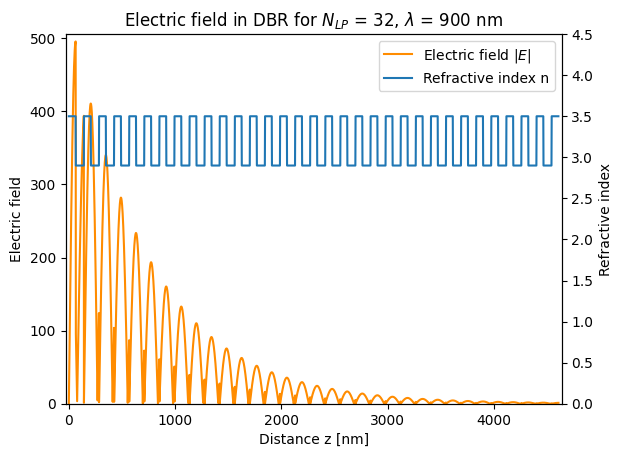

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(zr, Etot, color="darkorange", label=r"Electric field $|E|$")
lns2 = ax2.plot(np.linspace(0, zlim1, len(nidxt)), np.array(nidxt), label="Refractive index n")

ax1.set_xlabel("Distance z [nm]")
ax1.set_ylabel("Electric field")
ax2.set_ylabel("Refractive index")

plt.xlim([0-30*st, max(zr)+30*st])
ax1.set_ylim([0, max(Etot)+10])
ax2.set_ylim([0, 4.5])

plt.title("Electric field in DBR for $N_{LP}$ = " + str(N) + ", $\lambda$ = " + str(lda) + " nm")

# build legend
lns = lns1+lns2
labs = [ln.get_label() for ln in lns]
ax1.legend(lns, labs, loc='upper right')

plt.show()

# GODOOOOOOOOOOOOOOOOOOOO